In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import numpy as np
import quimb.tensor as qtn
from quimb.tensor.tensor_core import (
    ensure_dict,
    rand_uuid,
    tensor_contract,
    TensorNetwork,
)
import sys, os

N_MPI = 16
N_OMP = N_MKL = N_OPENBLAS = 1
# Number of cores used when performing linear algebra operations: N_MPI * N_OMP. Make sure this is less or equal to the number of total threadings.

os.environ['OMP_NUM_THREADS'] = f'{N_OMP}'
os.environ['MKL_NUM_THREADS'] = f'{N_MKL}'
os.environ['OPENBLAS_NUM_THREADS'] = f'{N_OPENBLAS}'
os.environ['MKL_DOMAIN_NUM_THREADS'] = f'{N_MKL}'
os.environ['MKL_DYNAMIC'] = 'FALSE'
os.environ['OMP_DYNAMIC'] = 'FALSE'

In [2]:
import quimb as qu
import numpy as np
import quimb.tensor as qtn
from quimb.tensor.tensor_core import (
    ensure_dict,
    rand_uuid,
    tensor_contract,
    TensorNetwork,
)
import sys, os

N_MPI = 16
N_OMP = N_MKL = N_OPENBLAS = 1
# Number of cores used when performing linear algebra operations: N_MPI * N_OMP. Make sure this is less or equal to the number of total threadings.

os.environ['OMP_NUM_THREADS'] = f'{N_OMP}'
os.environ['MKL_NUM_THREADS'] = f'{N_MKL}'
os.environ['OPENBLAS_NUM_THREADS'] = f'{N_OPENBLAS}'
os.environ['MKL_DOMAIN_NUM_THREADS'] = f'{N_MKL}'
os.environ['MKL_DYNAMIC'] = 'FALSE'
os.environ['OMP_DYNAMIC'] = 'FALSE'

def single_qubit_layer(circ, gate_round=None, g=1.0, h=0.0):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        if h != 0.0:
            circ.apply_gate(
                'RZ', -2*h, i, 
                gate_round=gate_round, parametrize=True)
            
        circ.apply_gate(
            'RX', -2*g, i, 
            gate_round=gate_round, parametrize=True)
        
        
def two_qubit_layer(circ, gate2='RZZ', gate_round=None, J=1.0):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    
    for i in regs[::2]:
        circ.apply_gate(
            gate2, -2*J, i, i + 1, gate_round=gate_round)
    
    for i in regs[1::2]:
        circ.apply_gate(
            gate2, -2*J, i, i + 1, gate_round=gate_round)

def ansatz_circuit(n, depth, gate2='RZZ', g=1.0, J=1.0, h=0.0, **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs, tags='ROUND_0')
    
    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r+1, g=g, h=h)
        
        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r+1, J=J)
        
    
    return circ

def mps_gate_with_mpo_lazy(self, mpo):
    """Apply an MPO to an MPS lazily, i.e. nothing is contracted, but the new
    TN object has the same outer indices as the original MPS.
    """
    mps_calc = self.copy()
    mpo_calc = mpo.copy()

    outerid = self.site_ind_id
    innerid = rand_uuid() + "{}"

    mps_calc.site_ind_id = innerid
    mpo_calc.lower_ind_id = innerid
    mpo_calc.upper_ind_id = outerid

    mps_calc |= mpo_calc

    mps_calc._site_ind_id = outerid

    return mps_calc


def fix_inds_quimb(tn, ind_list, ind_value_list):
    """
    Fix a list of indices of the tensor network.
    Used for TN slicing.
    """
    tn_config = tn.copy()
    for ind, ind_value in zip(ind_list, ind_value_list):
        tn_config = tn_config.isel_({ind: ind_value})
    return tn_config

def generate_Kicked_Ising_peps(n, depth, g=1.0, J=1.0, h=0.0):
    circ = ansatz_circuit(n, depth, gate2='RZZ', g=g, J=J, h=h)
    psi = circ.psi.copy()
    for i in range(1,depth+1):
        for site in psi.sites:
            psi.contract_tags_([psi.site_tag_id.format(site), f'ROUND_{i}'], inplace=True, which='all')
    peps_psi = qtn.PEPS.from_TN(psi, Lx=depth+1, Ly=n, x_tag_id="ROUND_{}", y_tag_id="I{}", site_tag_id="I{},{}")
    for x in range(0,depth+1):
        for y in range(n):
            tn = peps_psi[[peps_psi.x_tag_id.format(x), peps_psi.y_tag_id.format(y)]]
            tn.add_tag(peps_psi.site_tag_id.format(x,y))
    return psi, peps_psi

def amplitude(peps_psi, chi, inds_values, inds=None, direction='xmax'):
    if inds is None:
        n = len(inds_values)
        inds = [f'k{ind}' for ind in range(n)]
    peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
    if direction == 'xmax':
        amplitude = peps_config.contract_boundary_from_xmax(xrange=(0, peps_config.Lx-1), max_bond=chi).contract()
    elif direction == 'xmin':
        # MPS contraction
        # amplitude = peps_config.contract_boundary_from_xmin(xrange=(0, 1), max_bond=chi).contract()
        amplitude = peps_config.contract()
    return amplitude

def amplitude_exact(peps_psi, inds_values, inds=None):
    if inds is None:
        n = len(inds_values)
        inds = [f'k{ind}' for ind in range(n)]
    peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
    amplitude = peps_config.contract()
    return amplitude

def enumerate_bitstrings(n):
    bitstrings = np.empty((2**n, n), dtype=int)
    for i in range(2**n):
        bitstrings[i] = [int(x) for x in list(f'{i:0{n}b}')]
    return bitstrings

def config2index(config):
    # transform a binary string to an index
    return int(''.join([str(x) for x in config]), 2)

def index2config(index, n):
    # transform an index to a binary configuration
    return tuple([int(x) for x in list(f'{index:0{n}b}')])

def amplitudes(n, depth, chi, direction='xmax', J=1.0, g=1.0, h=0.0):
    import time
    from quimb.utils import progbar as Progbar
    if direction == 'xmax':
        # no reuse
        circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
        configs = enumerate_bitstrings(n)
        amplitude_dict = {}
        normalizations = 0
        pg = Progbar(total=len(configs))
        t0 = time.time()
        for config in configs:
            amp = amplitude(peps_psi, chi, config, direction=direction)
            normalizations += abs(amp)**2
            amplitude_dict[tuple(config)] = amp
            pg.update()
        t1 = time.time()
        pg.close()
        for config in amplitude_dict.keys():
            amplitude_dict[config] /= np.sqrt(normalizations)

    elif direction == 'xmin':
        circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
        peps_psi = peps_psi.contract_boundary_from_xmin(xrange=(0, peps_psi.Lx), max_bond=chi).contract()
        configs = enumerate_bitstrings(n)
        amplitude_dict = {}
        normalizations = 0
        pg = Progbar(total=len(configs))
        t0 = time.time()
        for config in configs:
            amp = amplitude(peps_psi, chi, config, direction=direction)
            normalizations += abs(amp)**2
            amplitude_dict[tuple(config)] = amp
            pg.update()
        t1 = time.time()
        pg.close()
        for config in amplitude_dict.keys():
            amplitude_dict[config] /= np.sqrt(normalizations)

    print(f'Amplitudes computation time: {t1-t0:.2f} s, depth={depth}')
    amp_time = t1-t0
    return amplitude_dict, amp_time

def amplitudes_exact(n, depth, J=1.0, g=1.0, h=0.0):
    import time
    circ, peps_psi = generate_Kicked_Ising_peps(n, depth, J=J, g=g, h=h)
    configs = enumerate_bitstrings(n)
    state_vector = peps_psi.contract()
    amplitude_dict = {}
    normalizations = 0
    t0 = time.time()
    for config in configs:
        amp = amplitude_exact(state_vector, config)
        normalizations += abs(amp)**2
        amplitude_dict[tuple(config)] = amp
    t1 = time.time()
    print(f'Exact simulation normalization: {normalizations:.2f}')
        
    print(f'Exact amplitudes computation time: {t1-t0:.2f} s, depth={depth}')
    amp_time = t1-t0
    return amplitude_dict, amp_time

def whole_density_matrix(amplitude_dict, n):
    rho = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(2**n):
        for j in range(i, 2**n):
            config_i = index2config(i, n)
            config_j = index2config(j, n)
            rho[i, j] = amplitude_dict[config_i] * amplitude_dict[config_j].conjugate()
            rho[j, i] = rho[i, j].conjugate()
    return rho

def state_vector(amplitude_dict, n):
    psi = np.zeros(2**n, dtype=complex)
    for i in range(2**n):
        config_i = index2config(i, n)
        psi[i] = amplitude_dict[config_i]
    return psi

def partial_trace(rho, trace_qubits, reverse=True):
    n = int(np.log2(rho.shape[0]))
    dimensions = [2]*n
    for j in trace_qubits:
        dimension_traced = int(dimensions[j])
        if reverse:
            dimensions_left = dimensions[j+1:]
            dimensions_right = dimensions[:j]
            dimensions = dimensions_right + dimensions_left
        else:
            dimensions_left = dimensions[:j]
            dimensions_right = dimensions[j+1:]
            dimensions = dimensions_left + dimensions_right
        
        d_left = int(np.prod(dimensions_left))
        d_right = int(np.prod(dimensions_right))
        
        rho = rho.reshape(d_left, dimension_traced, d_right, d_left, dimension_traced, d_right)
        rho = rho.trace(axis1=1, axis2=4).reshape(d_left*d_right, d_left*d_right)
    
    return rho
        
def partial_trace_bipartition(rho, reverse=True):
    """
    Return the reduced density matrix of the first half of the system."""
    n = int(np.log2(rho.shape[0]))
    if n % 2 != 0:
        raise ValueError('The number of qubits must be even.')
    trace_qubit_no = int(n/2)
    rho = rho.reshape(2**trace_qubit_no, 2**trace_qubit_no, 2**trace_qubit_no, 2**trace_qubit_no)
    if reverse:
        rho = rho.trace(axis1=0, axis2=2)
    else:
        rho = rho.trace(axis1=1, axis2=3)
    return rho

def partial_trace_vec(vec, trace_systems=None, dimensions=None, reverse=True):
    """
    Partial trace over subsystems of multi-partite vector.

    Args:
        vec (vector_like): complex vector N
        trace_systems (list(int)): a list of subsystems (starting from 0) to
                                  trace over.
        dimensions (list(int)): a list of the dimensions of the subsystems.
                                If this is not set it will assume all
                                subsystems are qubits.
        reverse (bool): ordering of systems in operator.
            If True system-0 is the right most system in tensor product.
            If False system-0 is the left most system in tensor product.

    Returns:
        ndarray: A density matrix with the appropriate subsystems traced over.
    """
    
    n = int(np.log2(len(vec)))
    if dimensions is None:
        dimensions = [2] * n
    if trace_systems is None:
        # bipartition
        trace_systems = list(range(n // 2, n))
    # trace sys positions
    if reverse:
        dimensions = dimensions[::-1]
        trace_systems = len(dimensions) - 1 - np.array(trace_systems)

    rho = vec.reshape(dimensions)
    rho = np.tensordot(rho, rho.conj(), axes=(trace_systems, trace_systems))
    d = int(np.sqrt(np.product(rho.shape)))

    return rho.reshape(d, d)

def von_neumann_entropy(rho):
    """Compute entanglement entropy of the reduced density matrix. Logarithm has base 2."""
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 1e-15]
    return -np.sum(eigvals * np.log2(eigvals)) 

def maximum_entanglement_entropy(n):
    """Maximum entanglement entropy of n qubits. Logarithm has base 2."""
    return n

def compute_entanglement_entropy(n, depth, chi, direction='xmax', J=1.0, g=1.0, h=0.0, partial_trace_func=partial_trace_bipartition):
    # print(f'Current $\chi = {chi}$')
    print(f'depth={depth}')
    amplitude_dict, amp_time = amplitudes(n, depth, chi, direction=direction, J=J, g=g, h=h)
    if n<=10:
        partial_trace_func=partial_trace_bipartition
        rho = whole_density_matrix(amplitude_dict, n)
        rho = partial_trace_func(rho)
    else:
        partial_trace_func=partial_trace_vec
        vec = state_vector(amplitude_dict, n)
        rho = partial_trace_func(vec)
    return von_neumann_entropy(rho), np.trace(rho), amp_time

def compute_entanglement_entropy_exact(n, depth, J=1.0, g=1.0, h=0.0, partial_trace_func=partial_trace_vec):
    print(f'depth={depth}')
    amplitude_dict, amp_time = amplitudes_exact(n, depth, J=J, g=g, h=h)
    vec = state_vector(amplitude_dict, n)
    rho = partial_trace_func(vec)
    return von_neumann_entropy(rho), np.trace(rho), amp_time

def plot_bipartition_entropy_dynamics(n, total_depth, chi, chi_mps, entropies_func, entropies_mps, J=1.0, g=0.5, h=0.1, func=True):
    import matplotlib.pyplot as plt
    # print(J, g, h)
    fig, ax = plt.subplots()
    ax.plot(range(1, total_depth+1), entropies_func, label=f'TN function entropy, $\chi={chi}$')
    ax.plot(range(1, total_depth+1), entropies_mps, label=f'MPS entropy, $\chi={chi_mps}$')

    ax.set(xlabel='t', ylabel='Entropy',
              title=f'Bipartite EE dynamics of {n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
    ax.legend()
    plt.show()

In [3]:
n = 8
total_depth = 10
chi = 2
import matplotlib.pyplot as plt
def _entropy_growth(n, total_depth, chi, direction='xmax', J=1.0, g=0.5, h=0.1):
    entropies = []
    traces = []
    amp_times = []
    for depth in range(1, total_depth+1):
        # print(f'Computing entropy for depth {depth}')
        entropy, trace, amptime = compute_entanglement_entropy(n, depth, chi, direction=direction, J=J, g=g, h=h)
        print(f'Entropy: {entropy}, Trace: {trace}')
        entropies.append(entropy)
        traces.append(trace)
        amp_times.append(amptime)
    return entropies, traces, amp_times

entropies_func, traces_func, amp_times = _entropy_growth(n, total_depth, chi, direction='xmax', J=1.0, g=0.5, h=0.1)



depth=1


100%|##########| 256/256 [00:00<00:00, 342.20it/s]


Amplitudes computation time: 0.75 s, depth=1
Entropy: 0.52191019520901, Trace: (0.9999999999999986+0j)
depth=2


100%|##########| 256/256 [00:01<00:00, 167.84it/s]


Amplitudes computation time: 1.53 s, depth=2
Entropy: 1.0082177088677453, Trace: (1+0j)
depth=3


100%|##########| 256/256 [00:02<00:00, 110.40it/s]


Amplitudes computation time: 2.32 s, depth=3
Entropy: 1.6424910859091786, Trace: (0.9999999999999991+0j)
depth=4


100%|##########| 256/256 [00:03<00:00, 80.52it/s]


Amplitudes computation time: 3.18 s, depth=4
Entropy: 2.06069140055702, Trace: (1.0000000000000007+0j)
depth=5


100%|##########| 256/256 [00:04<00:00, 62.85it/s]


Amplitudes computation time: 4.07 s, depth=5
Entropy: 2.4005766856199577, Trace: (0.9999999999999996+0j)
depth=6


100%|##########| 256/256 [00:04<00:00, 52.50it/s]


Amplitudes computation time: 4.88 s, depth=6
Entropy: 2.165131127015383, Trace: (0.9999999999999998+0j)
depth=7


100%|##########| 256/256 [00:05<00:00, 44.44it/s]


Amplitudes computation time: 5.76 s, depth=7
Entropy: 2.0528940248621064, Trace: (0.9999999999999997+0j)
depth=8


100%|##########| 256/256 [00:06<00:00, 38.61it/s]


Amplitudes computation time: 6.63 s, depth=8
Entropy: 1.939747865963093, Trace: (0.9999999999999997+0j)
depth=9


100%|##########| 256/256 [00:07<00:00, 34.05it/s]


Amplitudes computation time: 7.52 s, depth=9
Entropy: 2.03241385349749, Trace: (0.9999999999999996+0j)
depth=10


100%|##########| 256/256 [00:08<00:00, 30.18it/s]


Amplitudes computation time: 8.48 s, depth=10
Entropy: 2.118336739410628, Trace: (1.0000000000000009+0j)


In [4]:
entropies_func

[0.52191019520901,
 1.0082177088677453,
 1.6424910859091786,
 2.06069140055702,
 2.4005766856199577,
 2.165131127015383,
 2.0528940248621064,
 1.939747865963093,
 2.03241385349749,
 2.118336739410628]

In [5]:
chi_mps_list =[2, 4, 8, 16]

entropies_mps_dict = {}

for chi_mps in chi_mps_list:
    entropies_mps, _, _ = _entropy_growth(n, total_depth, chi_mps, direction='xmin', J=1.0, g=0.5, h=0.1) 
    entropies_mps_dict[chi_mps] = entropies_mps

depth=1


100%|##########| 256/256 [00:00<00:00, 18293.27it/s]


Amplitudes computation time: 0.01 s, depth=1
Entropy: 0.5219101952090115, Trace: (0.9999999999999979+0j)
depth=2


100%|##########| 256/256 [00:00<00:00, 15046.62it/s]

Amplitudes computation time: 0.02 s, depth=2


Entropy: 0.8686389423704374, Trace: (1.0000000000000002+0j)
depth=3


100%|##########| 256/256 [00:00<00:00, 14258.76it/s]


Amplitudes computation time: 0.02 s, depth=3
Entropy: 0.9060711959323808, Trace: (1.0000000000000007+0j)
depth=4


100%|##########| 256/256 [00:00<00:00, 17887.35it/s]

Amplitudes computation time: 0.01 s, depth=4


Entropy: 0.9507913261592323, Trace: (0.9999999999999991+0j)
depth=5


100%|##########| 256/256 [00:00<00:00, 19506.62it/s]


Amplitudes computation time: 0.01 s, depth=5
Entropy: 0.9581827512088604, Trace: (1.0000000000000004+0j)
depth=6


100%|##########| 256/256 [00:00<00:00, 18876.99it/s]


Amplitudes computation time: 0.01 s, depth=6
Entropy: 0.7645664836868755, Trace: (1+0j)
depth=7


100%|##########| 256/256 [00:00<00:00, 18706.63it/s]


Amplitudes computation time: 0.01 s, depth=7
Entropy: 0.7906196943887269, Trace: (1.0000000000000004+0j)
depth=8


100%|##########| 256/256 [00:00<00:00, 17703.32it/s]


Amplitudes computation time: 0.01 s, depth=8
Entropy: 0.6294967112342653, Trace: (0.9999999999999978+0j)
depth=9


100%|##########| 256/256 [00:00<00:00, 17766.01it/s]

Amplitudes computation time: 0.01 s, depth=9


Entropy: 0.5732106944793727, Trace: (1.0000000000000004+0j)
depth=10


100%|##########| 256/256 [00:00<00:00, 17298.89it/s]


Amplitudes computation time: 0.01 s, depth=10
Entropy: 0.48011442558808143, Trace: (1.0000000000000004+0j)
depth=1


100%|##########| 256/256 [00:00<00:00, 19484.32it/s]


Amplitudes computation time: 0.01 s, depth=1
Entropy: 0.5219101952090115, Trace: (0.9999999999999979+0j)
depth=2


100%|##########| 256/256 [00:00<00:00, 18286.73it/s]

Amplitudes computation time: 0.01 s, depth=2


Entropy: 1.0082177088677464, Trace: (0.9999999999999999+0j)
depth=3


100%|##########| 256/256 [00:00<00:00, 17830.02it/s]

Amplitudes computation time: 0.01 s, depth=3


Entropy: 1.6048973463326668, Trace: (0.9999999999999996+0j)
depth=4


100%|##########| 256/256 [00:00<00:00, 20313.71it/s]

Amplitudes computation time: 0.01 s, depth=4


Entropy: 1.7653613669707875, Trace: (0.9999999999999999+0j)
depth=5


100%|##########| 256/256 [00:00<00:00, 18579.42it/s]

Amplitudes computation time: 0.01 s, depth=5


Entropy: 1.7676643782394628, Trace: (1.0000000000000002+0j)
depth=6


100%|##########| 256/256 [00:00<00:00, 17105.15it/s]


Amplitudes computation time: 0.01 s, depth=6
Entropy: 1.4434914024993866, Trace: (1+0j)
depth=7


100%|##########| 256/256 [00:00<00:00, 16783.77it/s]


Amplitudes computation time: 0.02 s, depth=7
Entropy: 1.468380958527048, Trace: (0.9999999999999996+0j)
depth=8


100%|##########| 256/256 [00:00<00:00, 18486.34it/s]


Amplitudes computation time: 0.01 s, depth=8
Entropy: 1.3513115096867763, Trace: (1.0000000000000013+0j)
depth=9


100%|##########| 256/256 [00:00<00:00, 18461.54it/s]


Amplitudes computation time: 0.01 s, depth=9
Entropy: 0.9545063059804926, Trace: (1.0000000000000009+0j)
depth=10


100%|##########| 256/256 [00:00<00:00, 17877.52it/s]

Amplitudes computation time: 0.01 s, depth=10
Entropy: 1.0199475138524645, Trace: (0.9999999999999996+0j)
depth=1



100%|##########| 256/256 [00:00<00:00, 17107.33it/s]


Amplitudes computation time: 0.01 s, depth=1
Entropy: 0.5219101952090115, Trace: (0.9999999999999979+0j)
depth=2


100%|##########| 256/256 [00:00<00:00, 18337.32it/s]


Amplitudes computation time: 0.01 s, depth=2
Entropy: 1.0082177088677464, Trace: (0.9999999999999999+0j)
depth=3


100%|##########| 256/256 [00:00<00:00, 18512.15it/s]

Amplitudes computation time: 0.01 s, depth=3


Entropy: 1.6211427025863157, Trace: (0.9999999999999996+0j)
depth=4


100%|##########| 256/256 [00:00<00:00, 19616.74it/s]

Amplitudes computation time: 0.01 s, depth=4


Entropy: 2.155105445733796, Trace: (1.0000000000000002+0j)
depth=5


100%|##########| 256/256 [00:00<00:00, 18164.84it/s]

Amplitudes computation time: 0.01 s, depth=5


Entropy: 2.293661496297574, Trace: (1+0j)
depth=6


100%|##########| 256/256 [00:00<00:00, 12936.18it/s]


Amplitudes computation time: 0.02 s, depth=6
Entropy: 2.107085112023995, Trace: (0.9999999999999989+0j)
depth=7


100%|##########| 256/256 [00:00<00:00, 18057.01it/s]


Amplitudes computation time: 0.01 s, depth=7
Entropy: 1.9797684365433617, Trace: (1.0000000000000004+0j)
depth=8


100%|##########| 256/256 [00:00<00:00, 19087.39it/s]


Amplitudes computation time: 0.01 s, depth=8
Entropy: 1.8338073283344642, Trace: (1.0000000000000009+0j)
depth=9


100%|##########| 256/256 [00:00<00:00, 18192.23it/s]


Amplitudes computation time: 0.01 s, depth=9
Entropy: 1.568580405304361, Trace: (0.9999999999999994+0j)
depth=10


100%|##########| 256/256 [00:00<00:00, 18814.47it/s]


Amplitudes computation time: 0.01 s, depth=10
Entropy: 1.7276648134372352, Trace: (0.9999999999999994+0j)
depth=1


100%|##########| 256/256 [00:00<00:00, 17313.11it/s]


Amplitudes computation time: 0.01 s, depth=1
Entropy: 0.5219101952090115, Trace: (0.9999999999999979+0j)
depth=2


100%|##########| 256/256 [00:00<00:00, 18025.78it/s]

Amplitudes computation time: 0.01 s, depth=2


Entropy: 1.0082177088677464, Trace: (0.9999999999999999+0j)
depth=3


100%|##########| 256/256 [00:00<00:00, 18069.16it/s]

Amplitudes computation time: 0.01 s, depth=3


Entropy: 1.6211427025863157, Trace: (0.9999999999999996+0j)
depth=4


100%|##########| 256/256 [00:00<00:00, 17763.65it/s]

Amplitudes computation time: 0.01 s, depth=4


Entropy: 2.1560565683491033, Trace: (1.0000000000000002+0j)
depth=5


100%|##########| 256/256 [00:00<00:00, 17612.43it/s]


Amplitudes computation time: 0.01 s, depth=5
Entropy: 2.328056882879086, Trace: (1+0j)
depth=6


100%|##########| 256/256 [00:00<00:00, 18289.84it/s]


Amplitudes computation time: 0.01 s, depth=6
Entropy: 2.217489653368313, Trace: (1.0000000000000004+0j)
depth=7


100%|##########| 256/256 [00:00<00:00, 13894.35it/s]


Amplitudes computation time: 0.02 s, depth=7
Entropy: 2.0806841131365927, Trace: (0.9999999999999998+0j)
depth=8


100%|##########| 256/256 [00:00<00:00, 17391.35it/s]

Amplitudes computation time: 0.01 s, depth=8


Entropy: 1.954683558918316, Trace: (1.0000000000000009+0j)
depth=9


100%|##########| 256/256 [00:00<00:00, 16699.98it/s]


Amplitudes computation time: 0.02 s, depth=9
Entropy: 1.7018638170467477, Trace: (1+0j)
depth=10


100%|##########| 256/256 [00:00<00:00, 14064.15it/s]

Amplitudes computation time: 0.02 s, depth=10
Entropy: 1.8554733677295938, Trace: (1.0000000000000004+0j)


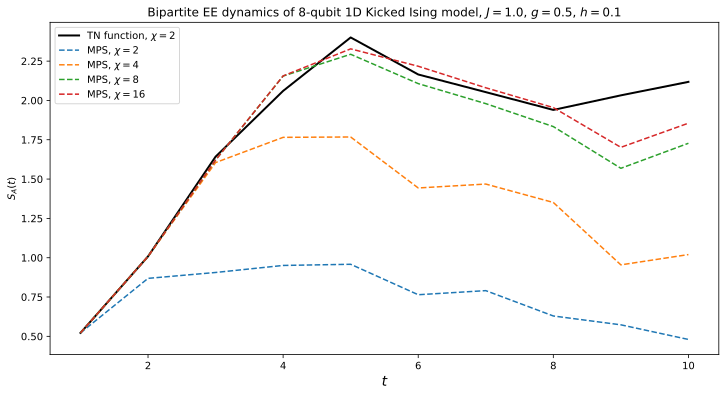

In [6]:
import matplotlib.pyplot as plt
J=1.0
g=0.5
h=0.1
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, total_depth+1), entropies_func, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
for chi_mps, entropies_mps in entropies_mps_dict.items():
    ax.plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--')

ax.set(ylabel=r'$S_A(t)$',
            title=f'Bipartite EE dynamics of {n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
ax.set_xlabel(r'$t$', fontsize=14)
ax.legend()
# plt.savefig(f'n={n}_bipartite_ee_kicked_ising.png', dpi=300)
plt.show()

In [127]:
n = 4
depth = 10
chi_list = [1,2,3,4]
# small system benchmark
entropies_func_benchmark_dict = {}
entropies_mps_benchmark_dict = {}
for chi in chi_list:
    entropies_func_benchmark, _ = _entropy_growth(n, depth, chi, direction='xmax', J=1.0, g=0.5, h=0.1)
    entropies_func_benchmark_dict[chi] = entropies_func_benchmark
    entropies_mps_benchmark, _ = _entropy_growth(n, depth, chi, direction='xmin', J=1.0, g=0.5, h=0.1)
    entropies_mps_benchmark_dict[chi] = entropies_mps_benchmark


Computing entropy for depth 1
Amplitudes computation time: 0.04 s
Computing entropy for depth 2
Amplitudes computation time: 0.06 s
Computing entropy for depth 3
Amplitudes computation time: 0.08 s
Computing entropy for depth 4
Amplitudes computation time: 0.11 s
Computing entropy for depth 5
Amplitudes computation time: 0.13 s
Computing entropy for depth 6
Amplitudes computation time: 0.15 s
Computing entropy for depth 7
Amplitudes computation time: 0.18 s
Computing entropy for depth 8
Amplitudes computation time: 0.21 s
Computing entropy for depth 9
Amplitudes computation time: 0.24 s
Computing entropy for depth 10
Amplitudes computation time: 0.26 s
Computing entropy for depth 1
Amplitudes computation time: 0.02 s
Computing entropy for depth 2
Amplitudes computation time: 0.02 s
Computing entropy for depth 3
Amplitudes computation time: 0.02 s
Computing entropy for depth 4
Amplitudes computation time: 0.02 s
Computing entropy for depth 5
Amplitudes computation time: 0.02 s
Computing

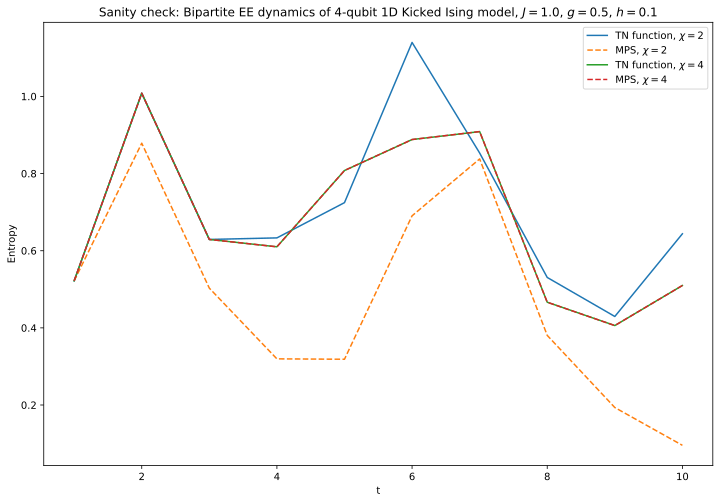

In [129]:
# plot benchmark
import matplotlib.pyplot as plt
J=1.0
g=0.5
h=0.1
fig, ax = plt.subplots(figsize=(12, 8))
for chi in chi_list[1::2]:
    ax.plot(range(1, depth+1), entropies_func_benchmark_dict[chi], label=f'TN function, $\chi={chi}$', linestyle='-')
# for chi in chi_list[1::2]:
    ax.plot(range(1, depth+1), entropies_mps_benchmark_dict[chi], label=f'MPS, $\chi={chi}$', linestyle='--')
# ax.plot(range(1, total_depth+1), entropies_func, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
# for chi_mps, entropies_mps in entropies_mps_dict.items():
#     ax.plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--')

ax.set(xlabel='t', ylabel='Entropy',
            title=f'Sanity check: Bipartite EE dynamics of {n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


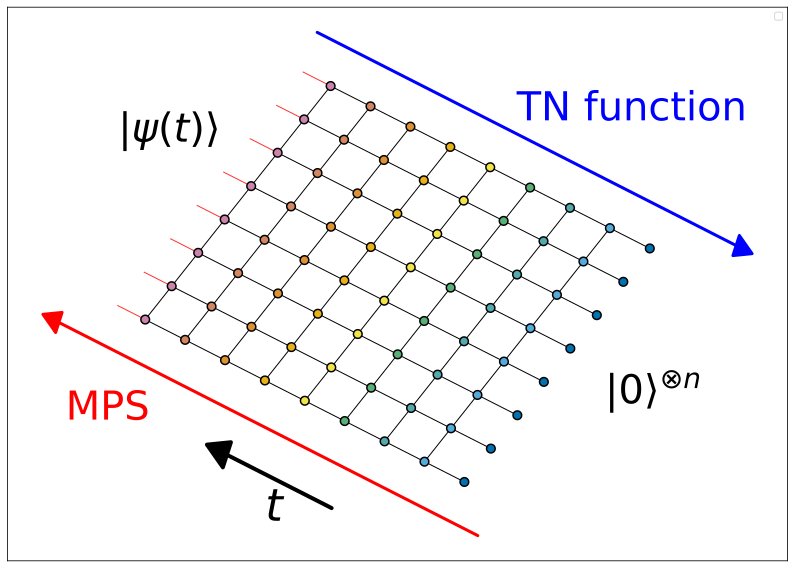

In [64]:
def get_3d_pos(i, j, k, a=22+180, b=45, p=0.2):
    import math
    return (
        + i * math.cos(math.pi * a / 180) + j * math.cos(math.pi * b / 180) / 2**p,
        - i * math.sin(math.pi * a / 180) + j * math.sin(math.pi * b / 180) / 2**p + k
    )
from matplotlib import pyplot as plt
depth = 8
circ1, psi1 = generate_Kicked_Ising_peps(8, depth, J=1.0, g=0.5, h=0.1)
fix = {
    psi1.site_tag(i, j): get_3d_pos(i, j, 1)
    for i, j in psi1.gen_site_coos()
}
# # fix the site inidices in plane below
fix.update({
    psi1.site_ind_id.format(j): get_3d_pos(psi1.Lx-1+0.7, j, 1)
    for j in range(psi1.Ly)
})
highlight_inds = [f'k{i}' for i in range(psi1.Ly)]

tags = ['PSI0']+[f'ROUND_{i}' for i in range(1, depth+1)] 
fig, ax = plt.subplots(figsize=(14, 10))
psi1.draw(tags, fix=fix,
    edge_color='black',
    edge_alpha=1.0,
    edge_scale=1.0,
    node_scale=1.5,
    node_outline_darkness=0.0,
    node_outline_size=1.5,
    ax=ax,
    highlight_inds=highlight_inds,
    show_inds=False,
    )
# plot a line
# ax.plot([get_3d_pos(0, 0, 1)[0], get_3d_pos(psi1.Lx-1, 0, 1)[0]], [get_3d_pos(0, 0, 1)[1], get_3d_pos(psi1.Lx-1, 0, 1)[1]], color='black', linestyle='--')
# ax.add_line(plt.Line2D([get_3d_pos(-1, 3.5, 1)[0], get_3d_pos(psi1.Lx+1, 3.5, 1)[0]], [get_3d_pos(-1, 3.5, 1)[1], get_3d_pos(psi1.Lx+1, 3.5, 1)[1]], color='black', linestyle='--'))
ax.arrow(get_3d_pos(-1, -1, 1)[0], get_3d_pos(-1, -1, 1)[1], get_3d_pos(psi1.Lx+0.5, -1, 1)[0]-get_3d_pos(-1, -1, 1)[0], get_3d_pos(psi1.Lx+0.5, -1, 1)[1]-get_3d_pos(-1, -1, 1)[1], head_width=0.4, head_length=0.4, fc='red', ec='red', linewidth=3)
ax.arrow(get_3d_pos(psi1.Lx, psi1.Ly, 1)[0], get_3d_pos(psi1.Lx, psi1.Ly, 1)[1], -get_3d_pos(psi1.Lx+0.5, -1, 1)[0]+get_3d_pos(-1, -1, 1)[0], -get_3d_pos(psi1.Lx+0.5, -1, 1)[1]+get_3d_pos(-1, -1, 1)[1], head_width=0.4, head_length=0.4, fc='blue', ec='blue', linewidth=3)

ax.arrow(get_3d_pos(2, -2, 1)[0], get_3d_pos(2, -2, 1)[1], (get_3d_pos(psi1.Lx+0.5, -1, 1)[0]-get_3d_pos(-1, -1, 1)[0])*0.25, (get_3d_pos(psi1.Lx+0.5, -1, 1)[1]-get_3d_pos(-1, -1, 1)[1])*0.25, head_width=0.5, head_length=0.5, fc='black', ec='black', linewidth=4)
ax.annotate('MPS', xy=(get_3d_pos(psi1.Lx-1, -3, 1)[0], get_3d_pos(psi1.Lx-1, -3, 1)[1]), color='red', fontsize=40)
ax.annotate('TN function', xy=(get_3d_pos(4, psi1.Ly, 1)[0], get_3d_pos(4, psi1.Ly, 1)[1]+0.25), color='blue', fontsize=40)
ax.annotate(r'$t$', xy=(get_3d_pos(3, -3, 1)[0], get_3d_pos(3, -3, 1)[1]), color='black', fontsize=45)
ax.annotate(r'$|\psi(t)\rangle$', xy=(get_3d_pos(11, 3.5, 1)[0], get_3d_pos(11, 3.5, 1)[1]), color='black', fontsize=40)
# ax.annotate(r'$A$', xy=(get_3d_pos(10, 5.5, 1)[0], get_3d_pos(10, 5.5, 1)[1]), color='black', fontsize=30)
ax.annotate(r'$|0\rangle^{\otimes n}$', xy=(get_3d_pos(-1.4, 3.2, 1)[0], get_3d_pos(-1.4, 3.2, 1)[1]), color='black', fontsize=40)
# ax.set_title('2D TN representation of the dynamics of 1D Kicked Ising model')
ax.legend()
fig.savefig('2d_tn_representation_kicked_ising.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


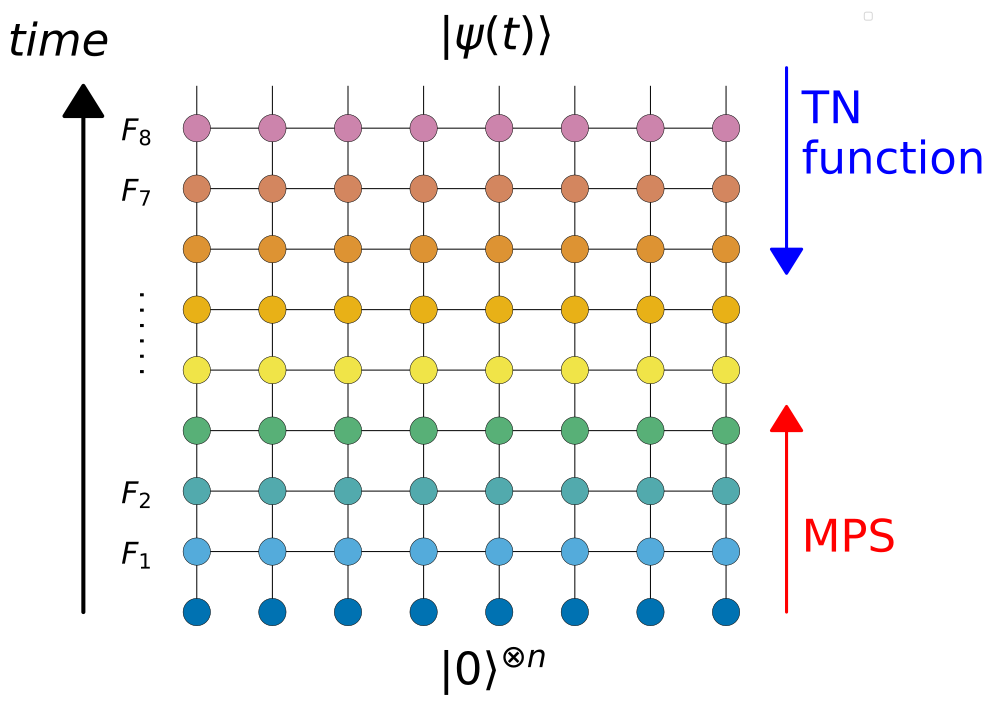

In [149]:
def get_3d_pos(i, j, k=1, a=-90, b=0.0, p=0.0, scale = 1):
    import math
    i = i*scale
    j = j*scale
    k = k*scale
    return (
        + i * math.cos(math.pi * a / 180) + j * math.cos(math.pi * b / 180) / 2**p,
        - i * math.sin(math.pi * a / 180) + j * math.sin(math.pi * b / 180) / 2**p + k
    )
from matplotlib import pyplot as plt
depth = 8
circ1, psi1 = generate_Kicked_Ising_peps(8, depth, J=1.0, g=0.5, h=0.1)
fix = {
    psi1.site_tag(i, j): get_3d_pos(i, j, 1)
    for i, j in psi1.gen_site_coos()
}
# # fix the site inidices in plane below
fix.update({
    psi1.site_ind_id.format(j): get_3d_pos(psi1.Lx-1+0.7, j, 1)
    for j in range(psi1.Ly)
})
highlight_inds = [f'k{i}' for i in range(psi1.Ly)]

tags = ['PSI0']+[f'ROUND_{i}' for i in range(1, depth+1)] 
fig, ax = plt.subplots(figsize=(14,10))
psi1.draw(tags, fix=fix,
    edge_color='black',
    edge_alpha=1.0,
    edge_scale=1.0,
    node_scale=15.0,
    node_outline_darkness=0.0,
    node_outline_size=0.5,
    ax=ax,
    # highlight_inds=highlight_inds,
    show_inds=False,
    )
# plot a line
# ax.plot([get_3d_pos(0, 0)[0], get_3d_pos(psi1.Lx-1, 0)[0]], [get_3d_pos(0, 0)[1], get_3d_pos(psi1.Lx-1, 0)[1]], color='black', linestyle='--')
# ax.add_line(plt.Line2D([get_3d_pos(-1, 3.5)[0], get_3d_pos(psi1.Lx+1, 3.5)[0]], [get_3d_pos(-1, 3.5)[1], get_3d_pos(psi1.Lx+1, 3.5)[1]], color='black', linestyle='--'))
ax.arrow(get_3d_pos(0, psi1.Ly-0.2)[0], get_3d_pos(0, psi1.Ly-0.2)[1], 0, +3,
         head_width=0.4, head_length=0.4, fc='red', ec='red', linewidth=3)
ax.arrow(get_3d_pos(psi1.Lx, psi1.Ly-0.2)[0], get_3d_pos(psi1.Lx, psi1.Ly-0.2)[1], 0, -3,
         head_width=0.4, head_length=0.4, fc='blue', ec='blue', linewidth=3)


ax.annotate('MPS', xy=(get_3d_pos(1, psi1.Ly)[0], get_3d_pos(1, psi1.Ly)[1]), color='red', fontsize=45)
ax.annotate('TN\nfunction', xy=(get_3d_pos(psi1.Lx-2, psi1.Ly)[0], get_3d_pos(psi1.Lx-2, psi1.Ly)[1]+0.25), color='blue', fontsize=45)
ax.annotate(r'$time$', xy=(get_3d_pos(psi1.Lx+0.2, -2.5)[0], get_3d_pos(psi1.Lx+0.2, -2.5)[1]), color='black', fontsize=45)
ax.arrow(get_3d_pos(0, -1.5)[0], get_3d_pos(0, -1.5)[1], 0, +8.2,
         head_width=0.5, head_length=0.5, fc='black', ec='black', linewidth=4)
ax.annotate(r'$|\psi(t)\rangle$', xy=(get_3d_pos(psi1.Lx+0.3, 3.2)[0], get_3d_pos(psi1.Lx+0.3, 3.2)[1]), color='black', fontsize=45)
# ax.annotate(r'$A$', xy=(get_3d_pos(10, 5.5)[0], get_3d_pos(10, 5.5)[1]), color='black', fontsize=30)
ax.annotate(r'$|0\rangle^{\otimes n}$', xy=(get_3d_pos(-1.2, 3.2)[0], get_3d_pos(-1.2, 3.2)[1]), color='black', fontsize=45)
for row in [1,2,7,8]:
    ax.annotate(f'$F_{row}$', xy=(get_3d_pos(row-0.2, -1)[0], get_3d_pos(row-0.2, -1)[1]), color='black', fontsize=30)
ax.annotate(f'$......$', xy=(get_3d_pos(4, -1)[0], get_3d_pos(4, -1)[1]), color='black', fontsize=30, rotation=90)

ax.set_xlim(-2.5, 9)
ax.set_ylim(-0.5, 11)
# make it frameless
ax.axis('off')
# ax.set_title('2D TN representation of the dynamics of 1D Kicked Ising model')
ax.legend()
plt.tight_layout()
fig.savefig('2d_tn_representation_kicked_ising.pdf')

In [219]:
n = 12
total_depth = 20
chi_func_list = [2, 4, 8, 16]
direction = 'xmax'
J = 1.0
g = 0.5
h = 0.1

entropies_func_dict = {}
amp_times_func_dict = {}

import concurrent.futures
for chi in chi_func_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi] * total_depth,  # chi is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies = []
        traces = []
        amp_times = []
        for entropy, trace, amp_time in results:
            entropies.append(entropy)
            traces.append(trace)
            amp_times.append(amp_time)
            
        entropies_func_dict[chi] = entropies
        amp_times_func_dict[chi] = amp_times

Amplitudes computation time: 76.54 s
Amplitudes computation time: 100.98 s
Amplitudes computation time: 167.44 s
Amplitudes computation time: 208.21 s
Amplitudes computation time: 225.88 s
Amplitudes computation time: 266.87 s
Amplitudes computation time: 306.93 s
Amplitudes computation time: 342.83 s
Amplitudes computation time: 378.30 s
Amplitudes computation time: 429.38 s
Amplitudes computation time: 445.91 s
Amplitudes computation time: 479.26 s
Amplitudes computation time: 509.01 s
Amplitudes computation time: 534.25 s
Amplitudes computation time: 562.55 s
Amplitudes computation time: 590.28 s
Amplitudes computation time: 614.38 s
Amplitudes computation time: 652.91 s
Amplitudes computation time: 676.87 s
Amplitudes computation time: 694.83 s
Amplitudes computation time: 62.88 s
Amplitudes computation time: 102.80 s
Amplitudes computation time: 145.29 s
Amplitudes computation time: 206.70 s
Amplitudes computation time: 231.72 s
Amplitudes computation time: 270.46 s
Amplitudes com

In [3]:
# from funcs import *
import numpy as np
import concurrent.futures
n = 12
total_depth = 20
chi_mps_list = [2, 4, 8, 16, 32, 64]
direction = 'xmin'
J = 1.0
g = 0.5
h = 0.1
entropies_mps_dict = {}
amp_times_mps_dict = {}
def save_mps_results(n, J, g, h, chi_mps, entropies_mps_dict):
    # Save the results to a txt file
    with open(f'./results/MPS_n={n}_J={J}_g={g}_h={h}.txt', 'a') as f:
        entropies_mps = entropies_mps_dict[chi_mps]
        for t in range(len(entropies_mps)):
            f.write(f'depth={t+1}, S_A={entropies_mps[t]}, chi={chi_mps}\n')

for chi_mps in chi_mps_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi_mps] * total_depth,  # chi_mps is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_mps = []
        traces_mps = []
        amp_times_mps = []
        for entropy, trace, amp_time in results:
            entropies_mps.append(entropy)
            traces_mps.append(trace)
            amp_times_mps.append(amp_time)
        entropies_mps_dict[chi_mps] = entropies_mps
        amp_times_mps_dict[chi_mps] = amp_times_mps
        
        save_mps_results(n, J, g, h, chi_mps, entropies_mps_dict)



depth=1depth=2



100%|##########| 16/16 [00:00<00:00, 425.64it/s]


Amplitudes computation time: 0.04 s, depth=1


100%|##########| 16/16 [00:00<00:00, 313.32it/s]


Amplitudes computation time: 0.05 s, depth=2


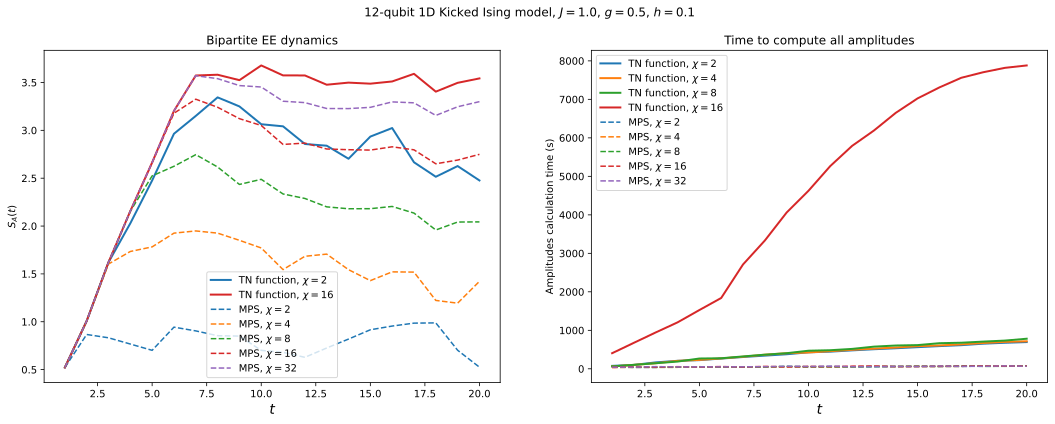

In [221]:
import matplotlib.pyplot as plt
J=1.0
g=0.5
h=0.1
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# make sure the colors for same chi are the same, and distinguishable for different chi
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for chi_func in chi_func_list[::3]:
    ax[0].plot(range(1, total_depth+1), entropies_func_dict[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=2.0, color=color_list[chi_func_list.index(chi_func)])
# ax[0].plot(range(1, total_depth+1), entropies, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
for chi_mps, entropies_mps in entropies_mps_dict.items():
    ax[0].plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--', color=color_list[chi_mps_list.index(chi_mps)])

ax[0].set(ylabel=r'$S_A(t)$',
            title=f'Bipartite EE dynamics')
ax[0].set_xlabel(r'$t$', fontsize=14)
ax[0].legend()
for chi_func in chi_func_list:
    ax[1].plot(range(1, total_depth+1), amp_times_func_dict[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=2.0, color=color_list[chi_func_list.index(chi_func)])
    
for chi_mps, amp_times_mps in amp_times_mps_dict.items():
    ax[1].plot(range(1, total_depth+1), amp_times_mps, linestyle='--', label=f'MPS, $\chi={chi_mps}$')
ax[1].set(ylabel=r'Amplitudes calculation time (s)',
            title=f'Time to compute all amplitudes')
ax[1].set_xlabel(r'$t$', fontsize=14)
ax[1].legend()
fig.suptitle(f'{n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
plt.savefig(f'n={n}_ee_dynamics_amp_time_J={J}_g={g}_h={h}.png', dpi=300)
plt.show()

$J=1.0$, $g=0.5$, $h=0$: **Integrable regime.**

In [239]:
n = 10
total_depth = 20
chi_func_list = [2, 4, 8, 16]
direction = 'xmax'
J = 1.0
g = 0.5
h = 0.0

entropies_func_dict_n10_integrable = {}
amp_times_func_dict_n10_integrable = {}

import concurrent.futures
for chi in chi_func_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi] * total_depth,  # chi is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies = []
        traces = []
        amp_times = []
        for entropy, trace, amp_time in results:
            entropies.append(entropy)
            traces.append(trace)
            amp_times.append(amp_time)
            
        entropies_func_dict_n10_integrable[chi] = entropies
        amp_times_func_dict_n10_integrable[chi] = amp_times

Amplitudes computation time: 15.55 s, depth=1
Amplitudes computation time: 21.73 s, depth=2
Amplitudes computation time: 33.31 s, depth=3
Amplitudes computation time: 38.49 s, depth=4
Amplitudes computation time: 46.83 s, depth=5
Amplitudes computation time: 54.58 s, depth=6
Amplitudes computation time: 62.17 s, depth=7
Amplitudes computation time: 70.08 s, depth=8
Amplitudes computation time: 78.70 s, depth=9
Amplitudes computation time: 86.87 s, depth=10
Amplitudes computation time: 92.02 s, depth=11
Amplitudes computation time: 97.47 s, depth=12
Amplitudes computation time: 103.49 s, depth=13
Amplitudes computation time: 109.73 s, depth=14
Amplitudes computation time: 113.02 s, depth=15
Amplitudes computation time: 119.05 s, depth=16
Amplitudes computation time: 124.89 s, depth=17
Amplitudes computation time: 129.31 s, depth=18
Amplitudes computation time: 134.24 s, depth=19
Amplitudes computation time: 138.88 s, depth=20
Amplitudes computation time: 13.99 s, depth=1
Amplitudes comp

In [238]:
n = 10
total_depth = 20
chi_mps_list = [2, 4, 8, 16, 32]
direction = 'xmin'
J = 1.0
g = 0.5
h = 0.0
entropies_mps_dict_n10_integrable = {}
amp_times_mps_dict_n10_integrable = {}

import concurrent.futures
for chi_mps in chi_mps_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi_mps] * total_depth,  # chi_mps is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_mps = []
        traces_mps = []
        amp_times_mps = []
        for entropy, trace, amp_time in results:
            entropies_mps.append(entropy)
            traces_mps.append(trace)
            amp_times_mps.append(amp_time)
        entropies_mps_dict_n10_integrable[chi_mps] = entropies_mps
        amp_times_mps_dict_n10_integrable[chi_mps] = amp_times_mps

Amplitudes computation time: 7.20 s, depth=1
Amplitudes computation time: 8.83 s, depth=5
Amplitudes computation time: 8.98 s, depth=3
Amplitudes computation time: 9.23 s, depth=2
Amplitudes computation time: 9.35 s, depth=7
Amplitudes computation time: 9.64 s, depth=8
Amplitudes computation time: 9.98 s, depth=4
Amplitudes computation time: 10.24 s, depth=11
Amplitudes computation time: 10.56 s, depth=6
Amplitudes computation time: 9.79 s, depth=12
Amplitudes computation time: 11.07 s, depth=9
Amplitudes computation time: 10.52 s, depth=14
Amplitudes computation time: 11.54 s, depth=10
Amplitudes computation time: 10.92 s, depth=15
Amplitudes computation time: 11.04 s, depth=13
Amplitudes computation time: 11.35 s, depth=19
Amplitudes computation time: 11.40 s, depth=18
Amplitudes computation time: 11.30 s, depth=16
Amplitudes computation time: 11.38 s, depth=17
Amplitudes computation time: 12.19 s, depth=20
Amplitudes computation time: 6.86 s, depth=1
Amplitudes computation time: 7.8

In [242]:
n = 10
total_depth = 20
chi_exact_list = [-1]
# direction = 'xmin'
J = 1.0
g = 0.5
h = 0.0
entropies_exact_dict_n10_integrable = {}
amp_times_exact_dict_n10_integrable = {}

import concurrent.futures
for chi_exact in chi_exact_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy_exact, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_exact = []
        traces_exact = []
        amp_times_exact = []
        for entropy, trace, amp_time in results:
            entropies_exact.append(entropy)
            traces_exact.append(trace)
            amp_times_exact.append(amp_time)
        entropies_exact_dict_n10_integrable[chi_exact] = entropies_exact
        amp_times_exact_dict_n10_integrable[chi_exact] = amp_times_exact

Exact amplitudes computation time: 1.00 s, depth=1
Exact amplitudes computation time: 1.09 s, depth=2
Exact amplitudes computation time: 0.42 s, depth=3
Exact amplitudes computation time: 0.47 s, depth=7
Exact amplitudes computation time: 0.57 s, depth=5
Exact amplitudes computation time: 0.65 s, depth=6
Exact amplitudes computation time: 0.71 s, depth=4
Exact amplitudes computation time: 0.62 s, depth=10Exact amplitudes computation time: 0.72 s, depth=8

Exact amplitudes computation time: 0.63 s, depth=9
Exact amplitudes computation time: 0.52 s, depth=12
Exact amplitudes computation time: 0.50 s, depth=11
Exact amplitudes computation time: 0.59 s, depth=16
Exact amplitudes computation time: 0.40 s, depth=13
Exact amplitudes computation time: 0.55 s, depth=14
Exact amplitudes computation time: 0.58 s, depth=15
Exact amplitudes computation time: 0.49 s, depth=19
Exact amplitudes computation time: 0.24 s, depth=18
Exact amplitudes computation time: 0.51 s, depth=17
Exact amplitudes comp

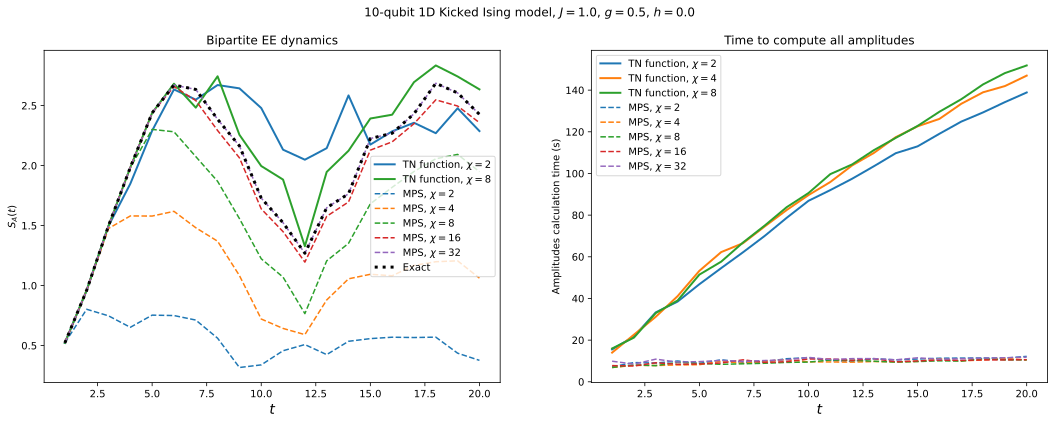

In [243]:
import matplotlib.pyplot as plt
J=1.0
g=0.5
h=0.0
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# make sure the colors for same chi are the same, and distinguishable for different chi
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for chi_func in chi_func_list[::2]:
    ax[0].plot(range(1, total_depth+1), entropies_func_dict_n10_integrable[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=2.0, color=color_list[chi_func_list.index(chi_func)])
# ax[0].plot(range(1, total_depth+1), entropies, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
for chi_mps, entropies_mps in entropies_mps_dict_n10_integrable.items():
    ax[0].plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--', color=color_list[chi_mps_list.index(chi_mps)])
for chi_exact, entropies_exact in entropies_exact_dict_n10_integrable.items():
    ax[0].plot(range(1, total_depth+1), entropies_exact, label=f'Exact', linestyle=':', color='black', linewidth=3.0)
ax[0].set(ylabel=r'$S_A(t)$',
            title=f'Bipartite EE dynamics')
ax[0].set_xlabel(r'$t$', fontsize=14)
ax[0].legend()
for chi_func in chi_func_list[:-1]:
    ax[1].plot(range(1, total_depth+1), amp_times_func_dict_n10_integrable[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=2.0, color=color_list[chi_func_list.index(chi_func)])
    
for chi_mps, amp_times_mps in amp_times_mps_dict_n10_integrable.items():
    ax[1].plot(range(1, total_depth+1), amp_times_mps, linestyle='--', label=f'MPS, $\chi={chi_mps}$')
ax[1].set(ylabel=r'Amplitudes calculation time (s)',
            title=f'Time to compute all amplitudes')
ax[1].set_xlabel(r'$t$', fontsize=14)
ax[1].legend()
fig.suptitle(f'{n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
plt.savefig(f'n={n}_ee_dynamics_amp_time_J={J}_g={g}_h={h}.png', dpi=300)
plt.show()

In [232]:
n = 10
total_depth = 10
chi_func_list = [2, 4, 8]
direction = 'xmax'
J = 1.0
g = 0.5
h = 0.1

entropies_func_dict_n10_nonintegrable = {}
amp_times_func_dict_n10_nonintegrable = {}

import concurrent.futures
for chi in chi_func_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi] * total_depth,  # chi is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies = []
        traces = []
        amp_times = []
        for entropy, trace, amp_time in results:
            entropies.append(entropy)
            traces.append(trace)
            amp_times.append(amp_time)
            
        entropies_func_dict_n10_nonintegrable[chi] = entropies
        amp_times_func_dict_n10_nonintegrable[chi] = amp_times

Amplitudes computation time: 8.55 s, depth=1
Amplitudes computation time: 13.70 s, depth=2
Amplitudes computation time: 18.69 s, depth=3
Amplitudes computation time: 23.92 s, depth=4
Amplitudes computation time: 28.71 s, depth=5
Amplitudes computation time: 33.82 s, depth=6
Amplitudes computation time: 38.76 s, depth=7
Amplitudes computation time: 44.09 s, depth=8
Amplitudes computation time: 49.00 s, depth=9
Amplitudes computation time: 54.27 s, depth=10
Amplitudes computation time: 8.80 s, depth=1
Amplitudes computation time: 14.46 s, depth=2
Amplitudes computation time: 19.63 s, depth=3
Amplitudes computation time: 24.68 s, depth=4
Amplitudes computation time: 29.61 s, depth=5
Amplitudes computation time: 34.91 s, depth=6
Amplitudes computation time: 39.64 s, depth=7
Amplitudes computation time: 44.61 s, depth=8
Amplitudes computation time: 49.94 s, depth=9
Amplitudes computation time: 54.57 s, depth=10
Amplitudes computation time: 8.35 s, depth=1
Amplitudes computation time: 13.81 

In [233]:
n = 10
total_depth = 10
chi_mps_list = [2, 4, 8, 16, 32]
direction = 'xmin'
J = 1.0
g = 0.5
h = 0.1
entropies_mps_dict_n10_nonintegrable = {}
amp_times_mps_dict_n10_nonintegrable = {}

import concurrent.futures
for chi_mps in chi_mps_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi_mps] * total_depth,  # chi_mps is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_mps = []
        traces_mps = []
        amp_times_mps = []
        for entropy, trace, amp_time in results:
            entropies_mps.append(entropy)
            traces_mps.append(trace)
            amp_times_mps.append(amp_time)
        entropies_mps_dict_n10_nonintegrable[chi_mps] = entropies_mps
        amp_times_mps_dict_n10_nonintegrable[chi_mps] = amp_times_mps

Amplitudes computation time: 4.32 s, depth=1
Amplitudes computation time: 4.77 s, depth=2
Amplitudes computation time: 4.85 s, depth=3
Amplitudes computation time: 5.08 s, depth=4
Amplitudes computation time: 5.15 s, depth=5
Amplitudes computation time: 5.36 s, depth=6
Amplitudes computation time: 5.50 s, depth=7
Amplitudes computation time: 5.65 s, depth=8
Amplitudes computation time: 5.77 s, depth=9
Amplitudes computation time: 6.01 s, depth=10
Amplitudes computation time: 4.60 s, depth=1
Amplitudes computation time: 4.94 s, depth=2
Amplitudes computation time: 4.99 s, depth=3
Amplitudes computation time: 5.11 s, depth=4
Amplitudes computation time: 5.32 s, depth=7
Amplitudes computation time: 5.42 s, depth=5
Amplitudes computation time: 5.49 s, depth=6
Amplitudes computation time: 5.67 s, depth=8
Amplitudes computation time: 5.76 s, depth=9
Amplitudes computation time: 5.93 s, depth=10
Amplitudes computation time: 4.37 s, depth=1
Amplitudes computation time: 4.89 s, depth=3
Amplitud

In [229]:
n = 10
total_depth = 10
chi_exact_list = [-1]
# direction = 'xmin'
J = 1.0
g = 0.5
h = 0.1
entropies_exact_dict_n10_nonintegrable = {}
amp_times_exact_dict_n10_nonintegrable = {}

import concurrent.futures
for chi_exact in chi_exact_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy_exact, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_exact = []
        traces_exact = []
        amp_times_exact = []
        for entropy, trace, amp_time in results:
            entropies_exact.append(entropy)
            traces_exact.append(trace)
            amp_times_exact.append(amp_time)
        entropies_exact_dict_n10_nonintegrable[chi_exact] = entropies_exact
        amp_times_exact_dict_n10_nonintegrable[chi_exact] = amp_times_exact

Exact amplitudes computation time: 0.90 s, depth=1
Exact amplitudes computation time: 1.05 s, depth=2
Exact amplitudes computation time: 1.37 s, depth=3
Exact amplitudes computation time: 1.58 s, depth=4
Exact amplitudes computation time: 1.75 s, depth=5
Exact amplitudes computation time: 1.89 s, depth=6
Exact amplitudes computation time: 2.13 s, depth=7
Exact amplitudes computation time: 4.58 s, depth=8
Exact amplitudes computation time: 4.71 s, depth=9
Exact amplitudes computation time: 4.98 s, depth=10


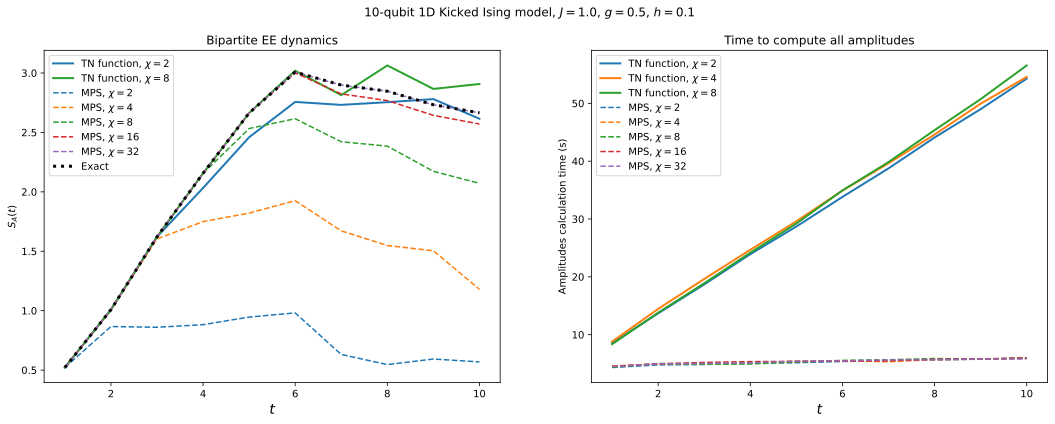

In [237]:
import matplotlib.pyplot as plt
J=1.0
g=0.5
h=0.1
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# make sure the colors for same chi are the same, and distinguishable for different chi
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for chi_func in chi_func_list[::2]:
    ax[0].plot(range(1, total_depth+1), entropies_func_dict_n10_nonintegrable[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=2.0, color=color_list[chi_func_list.index(chi_func)])
# ax[0].plot(range(1, total_depth+1), entropies, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
for chi_mps, entropies_mps in entropies_mps_dict_n10_nonintegrable.items():
    ax[0].plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--', color=color_list[chi_mps_list.index(chi_mps)])
for chi_exact, entropies_exact in entropies_exact_dict_n10_nonintegrable.items():
    ax[0].plot(range(1, total_depth+1), entropies_exact, label=f'Exact', linestyle=':', color='black', linewidth=3.0)

ax[0].set(ylabel=r'$S_A(t)$',
            title=f'Bipartite EE dynamics')
ax[0].set_xlabel(r'$t$', fontsize=14)
ax[0].legend()
for chi_func in chi_func_list:
    ax[1].plot(range(1, total_depth+1), amp_times_func_dict_n10_nonintegrable[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=2.0, color=color_list[chi_func_list.index(chi_func)])
    
for chi_mps, amp_times_mps in amp_times_mps_dict_n10_nonintegrable.items():
    ax[1].plot(range(1, total_depth+1), amp_times_mps, linestyle='--', label=f'MPS, $\chi={chi_mps}$')
ax[1].set(ylabel=r'Amplitudes calculation time (s)',
            title=f'Time to compute all amplitudes')
ax[1].set_xlabel(r'$t$', fontsize=14)
ax[1].legend()
fig.suptitle(f'{n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$')
plt.savefig(f'n={n}_ee_dynamics_amp_time_J={J}_g={g}_h={h}.png', dpi=300)
plt.show()

$J=0.31$, $g=\pi/4$, $h=0$: **Paramagnetic phase, integrable. TE insensitive to $h$.**

In [201]:
n = 10
total_depth = 10
chi_func_list = [2, 4, 8, 16]
direction = 'xmax'
J = 0.31
g = np.pi/4
h = 0.0

entropies_func_dict_para = {}
amp_times_func_dict_para = {}

import concurrent.futures
for chi in chi_func_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi] * total_depth,  # chi is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies = []
        traces = []
        amp_times = []
        for entropy, trace, amp_time in results:
            entropies.append(entropy)
            traces.append(trace)
            amp_times.append(amp_time)
            
        entropies_func_dict_para[chi] = entropies
        amp_times_func_dict_para[chi] = amp_times

Amplitudes computation time: 8.70 s
Amplitudes computation time: 13.80 s
Amplitudes computation time: 19.28 s
Amplitudes computation time: 24.60 s
Amplitudes computation time: 29.04 s
Amplitudes computation time: 33.92 s
Amplitudes computation time: 38.55 s
Amplitudes computation time: 43.68 s
Amplitudes computation time: 48.40 s
Amplitudes computation time: 53.10 s
Amplitudes computation time: 8.80 s
Amplitudes computation time: 13.70 s
Amplitudes computation time: 18.82 s
Amplitudes computation time: 24.10 s
Amplitudes computation time: 29.06 s
Amplitudes computation time: 33.62 s
Amplitudes computation time: 38.38 s
Amplitudes computation time: 43.53 s
Amplitudes computation time: 48.17 s
Amplitudes computation time: 52.94 s
Amplitudes computation time: 8.28 s
Amplitudes computation time: 13.51 s
Amplitudes computation time: 17.92 s
Amplitudes computation time: 23.01 s
Amplitudes computation time: 27.51 s
Amplitudes computation time: 32.51 s
Amplitudes computation time: 37.70 s
Ampl

In [202]:
chi_mps_list = [2, 4, 8, 16, 32]
direction = 'xmin'
J = 0.31
g = np.pi/4
h = 0.0
entropies_mps_dict_para = {}
amp_times_mps_dict_para = {}
import concurrent.futures
for chi_mps in chi_mps_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi_mps] * total_depth,  # chi_mps is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_mps = []
        traces_mps = []
        amp_times_mps = []
        for entropy, trace, amp_time in results:
            entropies_mps.append(entropy)
            traces_mps.append(trace)
            amp_times_mps.append(amp_time)
        entropies_mps_dict_para[chi_mps] = entropies_mps
        amp_times_mps_dict_para[chi_mps] = amp_times_mps

Amplitudes computation time: 4.70 s
Amplitudes computation time: 4.72 s
Amplitudes computation time: 4.96 s
Amplitudes computation time: 5.01 sAmplitudes computation time: 5.03 s

Amplitudes computation time: 5.21 s
Amplitudes computation time: 5.30 s
Amplitudes computation time: 5.37 s
Amplitudes computation time: 5.58 s
Amplitudes computation time: 5.86 s
Amplitudes computation time: 4.24 s
Amplitudes computation time: 4.36 s
Amplitudes computation time: 4.66 s
Amplitudes computation time: 4.64 s
Amplitudes computation time: 4.73 s
Amplitudes computation time: 4.83 s
Amplitudes computation time: 4.99 s
Amplitudes computation time: 5.20 s
Amplitudes computation time: 5.50 s
Amplitudes computation time: 5.48 s
Amplitudes computation time: 4.21 s
Amplitudes computation time: 4.44 s
Amplitudes computation time: 4.56 s
Amplitudes computation time: 4.75 s
Amplitudes computation time: 4.80 s
Amplitudes computation time: 4.81 s
Amplitudes computation time: 4.87 s
Amplitudes computation time:

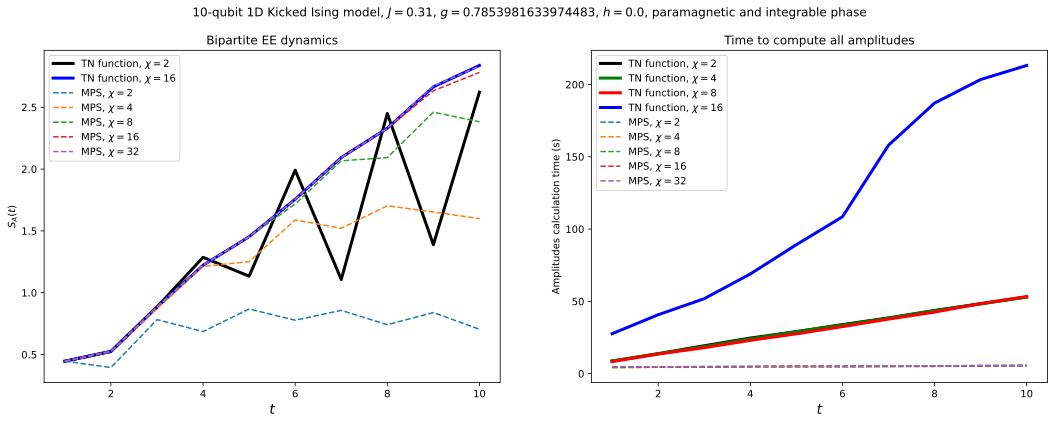

In [214]:
import matplotlib.pyplot as plt
J = 0.31
g = np.pi/4
h = 0.0
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# make sure the colors for same chi are the same, and distinguishable for different chi
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
func_color_list = ['black', 'green', 'red', 'blue']
for chi_func in chi_func_list[::3]:
    ax[0].plot(range(1, total_depth+1), entropies_func_dict_para[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=3.0, color=func_color_list[chi_func_list.index(chi_func)])
# ax[0].plot(range(1, total_depth+1), entropies, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
for chi_mps, entropies_mps in entropies_mps_dict_para.items():
    ax[0].plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--', color=color_list[chi_mps_list.index(chi_mps)])

ax[0].set(ylabel=r'$S_A(t)$',
            title=f'Bipartite EE dynamics')
ax[0].set_xlabel(r'$t$', fontsize=14)
ax[0].legend()
for chi_func in chi_func_list:
    ax[1].plot(range(1, total_depth+1), amp_times_func_dict_para[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=3.0, color=func_color_list[chi_func_list.index(chi_func)])
    
for chi_mps, amp_times_mps in amp_times_mps_dict_para.items():
    ax[1].plot(range(1, total_depth+1), amp_times_mps, linestyle='--', label=f'MPS, $\chi={chi_mps}$')
ax[1].set(ylabel=r'Amplitudes calculation time (s)',
            title=f'Time to compute all amplitudes')
ax[1].set_xlabel(r'$t$', fontsize=14)
ax[1].legend()
fig.suptitle(f'{n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$, paramagnetic and integrable phase')
plt.savefig(f'n={n}_ee_dynamics_amp_time_J={J}_g={g}_h={h}.png', dpi=300)
plt.show()

$J = \pi/4$, $g = 0.31$, $h = 0.2$: 
**Ordered & chaotic phase, sensitive to integrability breaking term $h$**

In [215]:
n = 10
total_depth = 10
chi_func_list = [2, 4, 8, 16]
direction = 'xmax'
J = np.pi/4
g = 0.31
h = 0.2

entropies_func_dict_ordered = {}
amp_times_func_dict_ordered = {}

import concurrent.futures
for chi in chi_func_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi] * total_depth,  # chi is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies = []
        traces = []
        amp_times = []
        for entropy, trace, amp_time in results:
            entropies.append(entropy)
            traces.append(trace)
            amp_times.append(amp_time)
            
        entropies_func_dict_ordered[chi] = entropies
        amp_times_func_dict_ordered[chi] = amp_times

Amplitudes computation time: 8.36 s
Amplitudes computation time: 14.14 s
Amplitudes computation time: 19.40 s
Amplitudes computation time: 24.77 s
Amplitudes computation time: 29.51 s
Amplitudes computation time: 34.10 s
Amplitudes computation time: 38.98 s
Amplitudes computation time: 43.97 s
Amplitudes computation time: 48.39 s
Amplitudes computation time: 53.44 s
Amplitudes computation time: 7.72 s
Amplitudes computation time: 12.87 s
Amplitudes computation time: 17.96 s
Amplitudes computation time: 22.81 s
Amplitudes computation time: 27.76 s
Amplitudes computation time: 32.21 s
Amplitudes computation time: 37.06 s
Amplitudes computation time: 42.09 s
Amplitudes computation time: 47.17 s
Amplitudes computation time: 51.88 s
Amplitudes computation time: 7.62 s
Amplitudes computation time: 12.76 s
Amplitudes computation time: 17.68 s
Amplitudes computation time: 22.57 s
Amplitudes computation time: 27.01 s
Amplitudes computation time: 32.53 s
Amplitudes computation time: 37.34 s
Ampl

In [216]:
chi_mps_list = [2, 4, 8, 16, 32]
direction = 'xmin'
J = np.pi/4
g = 0.31
h = 0.2
entropies_mps_dict_ordered = {}
amp_times_mps_dict_ordered = {}
import concurrent.futures
for chi_mps in chi_mps_list:
    # Parallel execution
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map each execution of compute_entanglement_entropy to a process
        results = executor.map(compute_entanglement_entropy, 
                            [n] * total_depth,  # n is constant across calls
                            range(1, total_depth + 1),  # depth varies from 1 to total_depth
                            [chi_mps] * total_depth,  # chi_mps is constant across calls
                            [direction] * total_depth,  # direction is constant
                            [J] * total_depth,  # J is constant
                            [g] * total_depth,  # g is constant
                            [h] * total_depth)  # h is constant

        entropies_mps = []
        traces_mps = []
        amp_times_mps = []
        for entropy, trace, amp_time in results:
            entropies_mps.append(entropy)
            traces_mps.append(trace)
            amp_times_mps.append(amp_time)
        entropies_mps_dict_ordered[chi_mps] = entropies_mps
        amp_times_mps_dict_ordered[chi_mps] = amp_times_mps

Amplitudes computation time: 4.43 s
Amplitudes computation time: 4.75 s
Amplitudes computation time: 4.88 s
Amplitudes computation time: 4.89 s
Amplitudes computation time: 5.27 s
Amplitudes computation time: 5.28 s
Amplitudes computation time: 5.32 s
Amplitudes computation time: 5.70 s
Amplitudes computation time: 5.73 s
Amplitudes computation time: 5.95 s
Amplitudes computation time: 4.23 s
Amplitudes computation time: 4.86 s
Amplitudes computation time: 4.90 s
Amplitudes computation time: 4.96 s
Amplitudes computation time: 4.99 s
Amplitudes computation time: 5.02 s
Amplitudes computation time: 5.18 s
Amplitudes computation time: 5.58 s
Amplitudes computation time: 5.80 s
Amplitudes computation time: 5.84 s
Amplitudes computation time: 4.41 s
Amplitudes computation time: 4.90 s
Amplitudes computation time: 5.07 s
Amplitudes computation time: 5.07 s
Amplitudes computation time: 5.32 s
Amplitudes computation time: 5.32 s
Amplitudes computation time: 5.58 s
Amplitudes computation time:

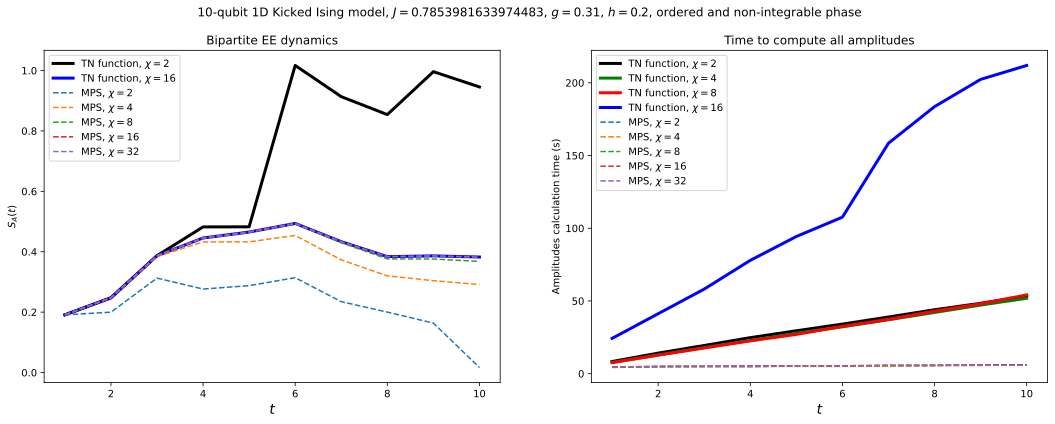

In [217]:
import matplotlib.pyplot as plt
J = np.pi/4
g = 0.31
h = 0.2
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# make sure the colors for same chi are the same, and distinguishable for different chi
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
func_color_list = ['black', 'green', 'red', 'blue']
for chi_func in chi_func_list[::3]:
    ax[0].plot(range(1, total_depth+1), entropies_func_dict_ordered[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=3.0, color=func_color_list[chi_func_list.index(chi_func)])
# ax[0].plot(range(1, total_depth+1), entropies, label=f'TN function, $\chi={chi}$', color='black', linewidth=2.0)
for chi_mps, entropies_mps in entropies_mps_dict_ordered.items():
    ax[0].plot(range(1, total_depth+1), entropies_mps, label=f'MPS, $\chi={chi_mps}$', linestyle='--', color=color_list[chi_mps_list.index(chi_mps)])

ax[0].set(ylabel=r'$S_A(t)$',
            title=f'Bipartite EE dynamics')
ax[0].set_xlabel(r'$t$', fontsize=14)
ax[0].legend()
for chi_func in chi_func_list:
    ax[1].plot(range(1, total_depth+1), amp_times_func_dict_ordered[chi_func], label=f'TN function, $\chi={chi_func}$', linewidth=3.0, color=func_color_list[chi_func_list.index(chi_func)])
    
for chi_mps, amp_times_mps in amp_times_mps_dict_ordered.items():
    ax[1].plot(range(1, total_depth+1), amp_times_mps, linestyle='--', label=f'MPS, $\chi={chi_mps}$')
ax[1].set(ylabel=r'Amplitudes calculation time (s)',
            title=f'Time to compute all amplitudes')
ax[1].set_xlabel(r'$t$', fontsize=14)
ax[1].legend()
fig.suptitle(f'{n}-qubit 1D Kicked Ising model, $J={J}$, $g={g}$, $h={h}$, ordered and non-integrable phase')
plt.savefig(f'n={n}_ee_dynamics_amp_time_J={J}_g={g}_h={h}.png', dpi=300)
plt.show()

In [ ]:
def config2index(config):
    # transform a binary string to an index
    return int(''.join([str(x) for x in config]), 2)

def index2config(index, n):
    # transform an index to a binary configuration
    return tuple([int(x) for x in list(f'{index:0{n}b}')])

def whole_density_matrix(amplitude_dict, n):
    rho = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(2**n):
        for j in range(i, 2**n):
            config_i = index2config(i, n)
            config_j = index2config(j, n)
            rho[i, j] = amplitude_dict[config_i] * amplitude_dict[config_j].conjugate()
            rho[j, i] = rho[i, j].conjugate()
    return rho

In [ ]:
rho = whole_density_matrix(amplitude_dict, n)
rho0 = np.zeros((2**n, 2**n), dtype=complex)
for config1, amp1 in amplitude_dict.items():
    for config2, amp2 in amplitude_dict.items():
        i = config2index(config1)
        j = config2index(config2)
        rho0[i, j] = amp1 * amp2.conjugate()
rho == rho0

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  Tru

In [310]:
f'{4:0{4}b}'

'0100'

In [311]:
int('0100', 2)

4

In [312]:
trace_qubits = [2, 3]
reverse = True

def partial_trace(rho, trace_qubits, reverse=True):
    n = int(np.log2(rho.shape[0]))
    dimensions = [2]*n
    for j in trace_qubits:
        dimension_traced = int(dimensions[j])
        if reverse:
            dimensions_left = dimensions[j+1:]
            dimensions_right = dimensions[:j]
            dimensions = dimensions_right + dimensions_left
        else:
            dimensions_left = dimensions[:j]
            dimensions_right = dimensions[j+1:]
            dimensions = dimensions_left + dimensions_right
        
        d_left = int(np.prod(dimensions_left))
        d_right = int(np.prod(dimensions_right))
        
        rho = rho.reshape(d_left, dimension_traced, d_right, d_left, dimension_traced, d_right)
        rho = rho.trace(axis1=1, axis2=4).reshape(d_left*d_right, d_left*d_right)
    
    return rho
        
def partial_trace_bipartition(rho, reverse=True):
    n = int(np.log2(rho.shape[0]))
    if n % 2 != 0:
        raise ValueError('The number of qubits must be even.')
    trace_qubit_no = int(n/2)
    rho = rho.reshape(2**trace_qubit_no, 2**trace_qubit_no, 2**trace_qubit_no, 2**trace_qubit_no)
    if reverse:
        rho = rho.trace(axis1=0, axis2=2)
    else:
        rho = rho.trace(axis1=1, axis2=3)
    return rho

rdm_bipartition = partial_trace_bipartition(rho, reverse=True)
np.trace(rdm_bipartition)

(0.9999999999999982+0j)

In [313]:
randtn = np.random.rand(2,2,2,2)
# print(randtn)
print(randtn.trace(axis1=0, axis2=2))
print(np.einsum('ijik->jk', randtn))
print(partial_trace(randtn.reshape(4,4), [1], reverse=True))
print(partial_trace_bipartition(randtn.reshape(4,4), reverse=True))

[[1.09058417 1.29698204]
 [0.95160338 1.05450247]]
[[1.09058417 1.29698204]
 [0.95160338 1.05450247]]
[[1.09058417 1.29698204]
 [0.95160338 1.05450247]]
[[1.09058417 1.29698204]
 [0.95160338 1.05450247]]


In [314]:
def von_neumann_entropy(rho):
    """compute entanglement entropy of the reduced density matrix"""
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 1e-15]
    return -np.sum(eigvals * np.log2(eigvals))

def maximum_entanglement_entropy(n):
    return n

von_neumann_entropy(rdm_bipartition)


1.1840709881592681

# MPO-MPS form

In [3]:
n = 4
depth = 2
gate2 = 'RZZ'

circ = ansatz_circuit(n, depth, gate2=gate2)
psi = circ.psi.copy()

mpo, mps = psi.partition('PSI0')
site_ind_id = 'inner{}'
mps0 = qtn.MatrixProductState.from_TN(mps, L=n, cyclic=False, site_ind_id=site_ind_id)
mps_tid_site_map = {}
mpo_lower_inds = mps0.outer_inds()
for site in mps0.sites:
    tag = mps0.maybe_convert_coo(site)
    tid = mps0._get_tids_from_tags(tag)
    mps_tid_site_map[list(tid)[0]] = site

for ind in mps0.outer_inds():
    tid = list(mps0.ind_map[ind])[0]
    site_no = mps_tid_site_map[tid]
    mps0.reindex_({ind: mps0.site_ind_id.format(site_no)}) # needs changing

upper_ind_id = 'k{}'
lower_ind_id = 'inner{}'
mpo0 = qtn.tensor_arbgeom.TensorNetworkGenOperator.from_TN(mpo, upper_ind_id=upper_ind_id, lower_ind_id=lower_ind_id)
for site in mpo0.sites:
    mpo0.contract_tags_(mpo0.site_tag_id.format(site))


outerinds = mpo0.outer_inds()
upperinds = tuple(set(outerinds) - set(mpo_lower_inds))
lowerinds = mpo_lower_inds
print(upperinds)
print(lowerinds)
mpo_tid_site_map = {}
for site in mpo0.sites:
    tag = mpo0.maybe_convert_coo(site)
    tid = mpo0._get_tids_from_tags(tag)
    mpo_tid_site_map[list(tid)[0]] = site


for ind in lowerinds:
    tid = list(mpo0.ind_map[ind])[0]
    site_no = mpo_tid_site_map[tid]
    mpo0.reindex_({ind: mpo0.lower_ind_id.format(site_no)})
    
mpo0

('k0', 'k1', 'k3', 'k2')
('_8e208bAAAAA', '_8e208bAAAAB', '_8e208bAAAAC', '_8e208bAAAAD')


TensorNetworkGenOperator(tensors=4, indices=14)

# PEPS form

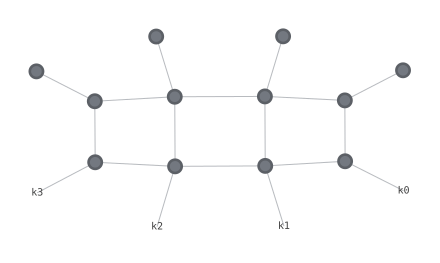

In [60]:
n = 4
depth = 2
gate2 = 'RZZ'

circ = ansatz_circuit(n, depth, gate2=gate2)
psi = circ.psi.copy()

for i in range(1,depth+1):
    for site in psi.sites:
        psi.contract_tags_([psi.site_tag_id.format(site), f'ROUND_{i}'], inplace=True, which='all')

psi.draw()

In [5]:
qtn.PEPS._EXTRA_PROPS

('_site_tag_id', '_x_tag_id', '_y_tag_id', '_Lx', '_Ly', '_site_ind_id')

In [6]:
randompeps = qtn.PEPS.rand(2,2,bond_dim=2)
randompeps

PEPS(tensors=4, indices=8, Lx=2, Ly=2, max_bond=2)

In [7]:
psi

TensorNetworkGenVector(tensors=12, indices=18)

I{},{}


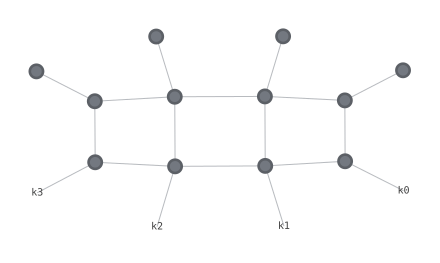

PEPS(tensors=12, indices=18, Lx=3, Ly=4, max_bond=2)

In [22]:
peps_psi = qtn.PEPS.from_TN(psi, Lx=depth+1, Ly=n, x_tag_id="ROUND_{}", y_tag_id="I{}", site_tag_id="I{},{}")
print(peps_psi.site_tag_id)
for x in range(0,depth+1):
    for y in range(n):
        tn = peps_psi[[peps_psi.x_tag_id.format(x), peps_psi.y_tag_id.format(y)]]
        tn.add_tag(peps_psi.site_tag_id.format(x,y))
peps_psi.draw()
# peps_psi.canonize_row(i=2, sweep='right')

# for a,b in peps_psi.gen_pairs():
#     tag_a = peps_psi.site_tag(*a)
#     tag_b = peps_psi.site_tag(*b)
#     print(tag_a, tag_b)
peps_psi

In [62]:
def generate_Kicked_Ising_peps(n, depth, g=1.0, J=1.0):
    circ = ansatz_circuit(n, depth, gate2=gate2, g=g, J=J)
    psi = circ.psi.copy()
    for i in range(1,depth+1):
        for site in psi.sites:
            psi.contract_tags_([psi.site_tag_id.format(site), f'ROUND_{i}'], inplace=True, which='all')
    peps_psi = qtn.PEPS.from_TN(psi, Lx=depth+1, Ly=n, x_tag_id="ROUND_{}", y_tag_id="I{}", site_tag_id="I{},{}")
    for x in range(0,depth+1):
        for y in range(n):
            tn = peps_psi[[peps_psi.x_tag_id.format(x), peps_psi.y_tag_id.format(y)]]
            tn.add_tag(peps_psi.site_tag_id.format(x,y))
    return peps_psi

### fixing indices (configurations)

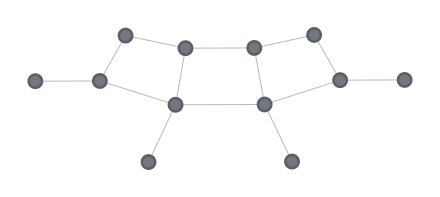

In [43]:
inds = ['k0', 'k1', 'k2', 'k3']
inds_values = [0, 0, 0, 0]
peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
peps_config.draw()

In [50]:
amplitude = peps_config.contract_boundary_from_xmax(xrange=(0, depth+1), max_bond=2).contract()

In [51]:
amplitude

(0.5017940036271457-0.09621495281125911j)

In [56]:
def amplitude(peps_psi, chi, inds_values, inds = ['k0', 'k1', 'k2', 'k3'], direction='xmax'):
    peps_config = fix_inds_quimb(peps_psi, inds, inds_values)
    if direction == 'xmax':
        amplitude = peps_config.contract_boundary_from_xmax(xrange=(0, peps_config.Lx), max_bond=chi).contract()
    elif direction == 'xmin':
        amplitude = peps_config.contract_boundary_from_xmin(xrange=(0, peps_config.Lx), max_bond=chi).contract()
    return amplitude